# Set up

In [176]:
# update path with data dir
import sys
sys.path.append('../../data/')

In [177]:
import warnings
# warnings.filterwarnings('ignore')

In [178]:
import pandas as pd
import patsy
import numpy as np
import itertools
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Getting data

In [179]:
file_name = '../csvs/element_gameweek_features_v02.csv'

In [180]:
element_gameweek_df = pd.read_csv(file_name)

In [181]:
current_event = 20

In [182]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [183]:
element_gameweek_df.fillna(0, inplace=True)

In [184]:
element_gameweek_df.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,element_type,value,is_sunday,...,rolling_avg_total_points_opposition_team,rolling_var_total_points_opposition_team,rolling_avg_total_points_against_opposition_team,rolling_var_total_points_against_opposition_team,rolling_avg_total_points_against_opposition_team_element_type,rolling_var_total_points_against_opposition_team_element_type,rolling_avg_total_points_home,avg_total_points_at_ground,var_total_points_at_ground,total_points
0,cech,1,1,1,1,13,1,1,50,1,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,3
1,cech,1,2,14,1,6,0,1,50,0,...,5.714286,10.373626,1.153846,0.474359,1.0,0.0,0.0,0.000000,0.0,3
2,cech,1,3,21,1,19,1,1,50,0,...,1.392857,2.914021,4.666667,15.615385,5.0,8.0,3.0,3.000000,0.0,3
3,cech,1,4,33,1,5,0,1,50,1,...,3.166667,8.873984,3.785714,8.562718,5.5,11.0,3.0,4.901786,0.0,1
4,cech,1,5,46,1,15,0,1,50,0,...,2.125000,3.893182,3.446429,10.906169,5.5,49.0,3.0,1.332237,0.0,2


In [185]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

# Modelling data

## Splitting data

In [186]:
last_train_event = 15

In [187]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [188]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.iloc[train_index], element_gameweek_df.iloc[test_index]

## Scaling data

In [189]:
scaled_feature_cols = [
    i for i in element_gameweek_df.columns if i not in [
        'safe_web_name', 'element', 'event', 'fixture', 'team',
        'opposition_team', 'element_type', 'was_home', 'is_sunday',
        'is_weekday', 'is_late', 'is_early', 'total_points'
    ]
]

scaled_feature_cols

['value',
 'rolling_avg_total_points_element',
 'rolling_var_total_points_element',
 'rolling_max_total_points_element',
 'rolling_avg_minutes_element_p3',
 'rolling_avg_bps_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_minutes_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_attempted_passes_element',
 'rolling_avg_completed_passes_element',
 'rolling_avg_recoveries_element',
 'rolling_avg_assists_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_winning_goals_element',
 'rolling_avg_tackled_element',
 'rolling_avg_dribbles_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_target_missed_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_open_play_crosses_element',
 'rolling_avg_offside_element',
 'rolling_avg_big_chances_missed_element',
 'rolling_avg_saves_element',
 'rolling_avg_goals_conceded_element',
 'rolli

In [190]:
scaled_df_train = element_gameweek_df_train.copy()
scaled_df_test = element_gameweek_df_test.copy()
scaled_df = element_gameweek_df.copy()

scaler = StandardScaler().fit(scaled_df_train[scaled_feature_cols].values)

scaled_df_train = scaler.transform(scaled_df_train[scaled_feature_cols].values)
scaled_df_test = scaler.transform(scaled_df_test[scaled_feature_cols].values)
scaled_df = scaler.transform(scaled_df[scaled_feature_cols].values)

element_gameweek_df_train[scaled_feature_cols] = scaled_df_train
element_gameweek_df_test[scaled_feature_cols] = scaled_df_test
element_gameweek_df[scaled_feature_cols] = scaled_df

/home/tom/footbot/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/tom/footbot/venv/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/tom/footbot/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [191]:
element_gameweek_df.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,element_type,value,is_sunday,...,rolling_avg_total_points_opposition_team,rolling_var_total_points_opposition_team,rolling_avg_total_points_against_opposition_team,rolling_var_total_points_against_opposition_team,rolling_avg_total_points_against_opposition_team_element_type,rolling_var_total_points_against_opposition_team_element_type,rolling_avg_total_points_home,avg_total_points_at_ground,var_total_points_at_ground,total_points
1,cech,1,2,14,1,6,0,1,-0.363966,0,...,3.141730,0.565297,-1.997465,-2.129883,-1.614392,-1.346934,-1.259965,-1.241969,-0.594088,3
2,cech,1,3,21,1,19,1,1,-0.363966,0,...,-1.805706,-1.614084,1.861369,1.946461,1.561519,-0.039872,-0.050375,0.002013,-0.594088,3
3,cech,1,4,33,1,5,0,1,-0.363966,1,...,0.225060,0.127165,0.893643,0.047706,1.958508,0.450276,-0.050375,0.790608,-0.594088,1
4,cech,1,5,46,1,15,0,1,-0.363966,0,...,-0.967504,-1.328015,0.520938,0.678622,1.958508,6.658818,-0.050375,-0.689543,-0.594088,2
5,cech,1,6,51,1,8,1,1,-0.363966,1,...,-0.603602,-0.012704,-0.440250,0.189402,-0.820415,-1.265243,-0.050375,0.002013,-0.594088,11


## Building model

In [192]:
formula = \
'total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name', 'element', 'event', 'fixture', 'team',
     'opposition_team', 'element_type',
     'rolling_avg_attempted_passes_element', 'rolling_var_total_points_against_opposition_team',
     'rolling_var_total_points_own_team', 'rolling_var_total_points_opposition_team',
     'rolling_var_total_points_element_type', 'rolling_var_total_points_against_opposition_team_element_type',
     'var_total_points_at_ground',
     'total_points'
 ]])

In [193]:
print(formula)

total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + was_home + value + is_sunday + is_weekday + is_late + is_early + rolling_avg_total_points_element + rolling_var_total_points_element + rolling_max_total_points_element + rolling_avg_minutes_element_p3 + rolling_avg_bps_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_minutes_element + rolling_avg_clean_sheets_element + rolling_avg_completed_passes_element + rolling_avg_recoveries_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_dribbles_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolli

In [194]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [195]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Selecting features

In [196]:
estimator = SVR(kernel="linear", C=1, epsilon=1)
selector = RFECV(estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
selector = selector.fit(X, y.ravel())

Fitting estimator with 435 features.
Fitting estimator with 434 features.
Fitting estimator with 433 features.
Fitting estimator with 432 features.
Fitting estimator with 431 features.
Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
F

Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
F

Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
Fitting estimator with 407 features.
Fitting estimator with 406 features.
Fitting estimator with 405 features.
Fitting estimator with 404 features.
Fitting estimator with 403 features.
Fitting estimator with 402 features.
Fitting estimator with 401 features.
Fitting estimator with 400 features.
Fitting estimator with 399 features.
Fitting estimator with 398 features.
Fitting estimator with 397 features.
Fitting estimator with 396 features.
F

In [199]:
features = patsy.dmatrices(formula, element_gameweek_df, return_type='dataframe')[1].columns
selected_features = pd.Series(features)[selector.support_]
selected_features

2                                       C(element)[T.4]
4                                       C(element)[T.6]
6                                       C(element)[T.8]
7                                       C(element)[T.9]
9                                      C(element)[T.12]
10                                     C(element)[T.13]
11                                     C(element)[T.14]
14                                     C(element)[T.18]
16                                     C(element)[T.23]
19                                     C(element)[T.27]
20                                     C(element)[T.28]
23                                     C(element)[T.33]
26                                     C(element)[T.37]
27                                     C(element)[T.39]
28                                     C(element)[T.40]
29                                     C(element)[T.42]
30                                     C(element)[T.43]
33                                     C(element

In [200]:
X_sel = X[:,selector.support_]
X_train_sel = X_train[:,selector.support_]
X_test_sel = X_test[:,selector.support_]

## Tuning model

In [264]:
rbf_gamma = [0.01275, 0.013, 0.01325]
rbf_C = [6.80, 6.85, 6.90]
rbf_epsilon = [1.95, 2, 2.05]

rbf_parameters = {
    'gamma': rbf_gamma,
    'C': rbf_C,
    'epsilon': rbf_epsilon
}

In [265]:
gs_model_rbf = GridSearchCV(
    SVR(kernel='rbf'),
    rbf_parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=1)
gs_model_rbf.fit(X_sel, y.ravel())

Fitting 1 folds for each of 27 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   57.1s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=1,
             param_grid={'C': [6.8, 6.85, 6.9], 'epsilon': [1.95, 2, 2.05],
                         'gamma': [0.01275, 0.013, 0.01325]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
             verbose=1)

In [266]:
gs_model_rbf_df = pd.DataFrame(gs_model_rbf.cv_results_)[[
    'param_C','param_epsilon','param_gamma',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

gs_model_rbf_df[
    gs_model_rbf_df['split0_test_neg_mean_squared_error'] == \
    gs_model_rbf_df['split0_test_neg_mean_squared_error'].max()]


,param_C,param_epsilon,param_gamma,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
13,6.85,2,0.013,-2.259001,-9.488008


In [283]:
linear_C = [1.6, 1.625, 1.65]
linear_epsilon = [1.725, 1.75, 1.775]

linear_parameters = {
    'C': linear_C,
    'epsilon': linear_epsilon
}

In [284]:
gs_model_linear = GridSearchCV(
    SVR(kernel='linear'),
    linear_parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=1)
gs_model_linear.fit(X_sel, y.ravel())

Fitting 1 folds for each of 9 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   25.3s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated',
                           kernel='linear', max_iter=-1, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=1,
             param_grid={'C': [1.6, 1.625, 1.65],
                         'epsilon': [1.725, 1.75, 1.775]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
             verbose=1)

In [285]:
gs_model_linear_df = pd.DataFrame(gs_model_linear.cv_results_)[[
    'param_C','param_epsilon',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

gs_model_linear_df[
    gs_model_linear_df['split0_test_neg_mean_squared_error'] == \
    gs_model_linear_df['split0_test_neg_mean_squared_error'].max()]

,param_C,param_epsilon,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
4,1.625,1.75,-2.202931,-9.565783


# Evaluating model

In [270]:
model = SVR(kernel='rbf', gamma=0.013, C=6.85, epsilon=2.0)
model.fit(X_train_sel, y_train.ravel())

SVR(C=6.85, cache_size=200, coef0=0.0, degree=3, epsilon=2.0, gamma=0.013,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [271]:
# get predictions for test set
y_pred = model.predict(X_test_sel).flatten()

# calculate cross entropy loss for test set
test_loss = (mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred))
test_loss

(2.259000518861667, 9.48800791290286)

In [272]:
pd.Series(y_pred).describe()

count    948.000000
mean       2.889086
std        0.843341
min        1.021920
25%        2.270869
50%        2.860818
75%        3.444546
max        5.589426
dtype: float64

In [273]:
# refit model on all data
model_full = SVR(kernel='rbf', gamma=0.05, C=2.5, epsilon=1.5)
model_full.fit(X_sel, y.ravel())

SVR(C=2.5, cache_size=200, coef0=0.0, degree=3, epsilon=1.5, gamma=0.05,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [274]:
# get predictions for whole set
y_pred_full = model_full.predict(X_sel).flatten()

# calculate cross entropy loss for test set
test_loss_full = (mean_absolute_error(y, y_pred_full), mean_squared_error(y, y_pred_full))
test_loss_full

(1.8719902534375135, 7.299103431907756)

In [275]:
pd.Series(y_pred_full).describe()

count    3644.000000
mean        2.641043
std         1.001333
min         0.101995
25%         1.871014
50%         2.525510
75%         3.343224
max         7.077776
dtype: float64

In [276]:
abs(pd.Series(y.ravel()) - pd.Series(y_pred_full)).describe()

count    3644.000000
mean        1.871990
std         1.948281
min         0.000144
25%         0.688436
50%         1.474404
75%         2.177315
max        15.914270
dtype: float64

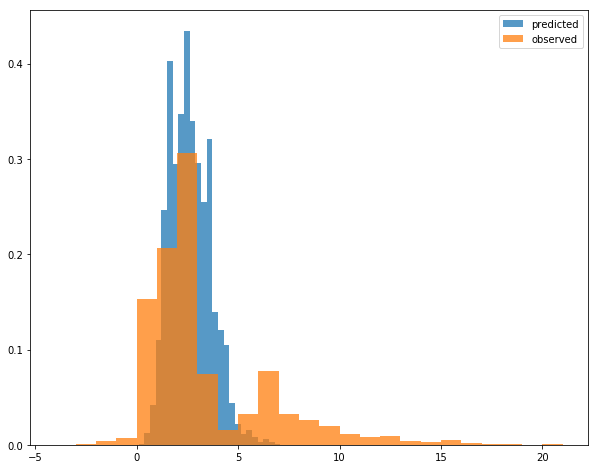

In [277]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(y_pred_full), bins=25, alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y.ravel()), bins=25, alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

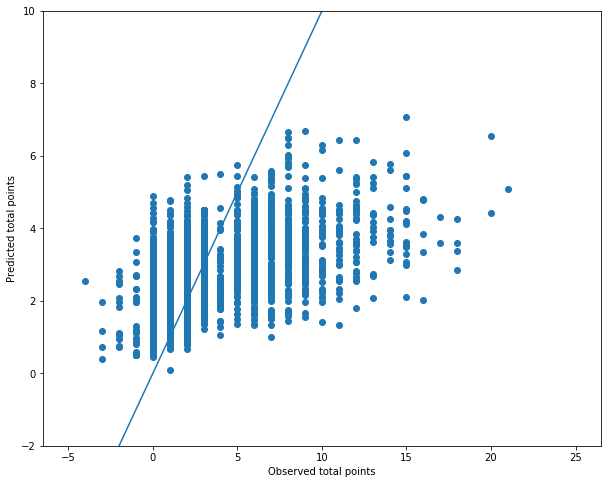

In [278]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y.ravel()), pd.Series(y_pred_full))
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-2, 10))
plt.show()